In [1]:
from matplotlib import pyplot as plt
import os
from scipy.io.wavfile import read
import scipy
import numpy as np
import torch
import librosa
from librosa.feature import melspectrogram
import scaleogram as scg 
from logmmse import logmmse_from_file
import pywt
import seaborn as sns
import pandas as pd
import sys
from AEspeech import AEspeech
# from phonetGM2 import Phonet
from SpecDatset import SpecDataset

In [2]:
from SpecDatset import SpecDataset
import time
import torch
import numpy as np
import pandas as pd
import os
import sys
from CAE import CAEn
PATH=os.getcwd()
sys.path.append(PATH+"/toolbox/")
import traintestsplit as tts

In [4]:
"""
Reconstruct error for random test file based on CAE/RAE models for wvlt and spectral representations.
Test wav files not used for training.
"""
PATH=os.getcwd()
path_audio=PATH+'/tedx_spanish_corpus/speech/test/test/'
wav_file=path_audio+os.listdir(path_audio)[0]
TIME_STEPS=256

fs_in, signal=read(wav_file)

#set loop parameters
rep='wvlt'
models=['CAE','RAE']
mod='CAE'
#     units=[]
unit=256
num_files=len(os.listdir(path_audio))

save_path=PATH+'/phonCSVs/'+rep+'/'

# for mod in models:
aespeech=AEspeech(model=mod,units=unit,rep=rep)
if rep=='spec':
    mat=aespeech.compute_spectrograms(wav_file)
    mat=aespeech.standard(mat)
if rep=='wvlt':
    mat,freqs=aespeech.compute_cwt(wav_file)

if torch.cuda.is_available():
    mat=mat.cuda()
to,bot=aespeech.AE.forward(mat)

if rep=='spec':
    to=aespeech.destandard(to)
    mat=aespeech.destandard(mat)


C:\Users\Gabriel\Anaconda3\lib\site-packages\torch\nn\functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [6]:
to.shape

torch.Size([154, 1, 64, 256])

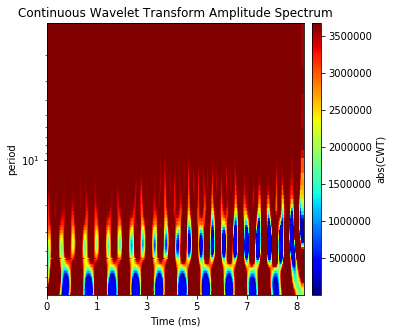

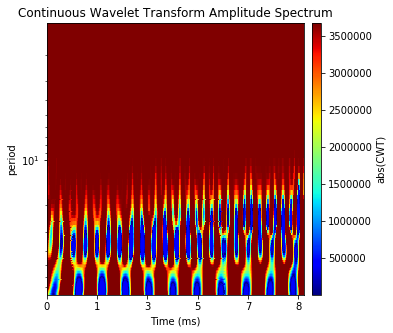

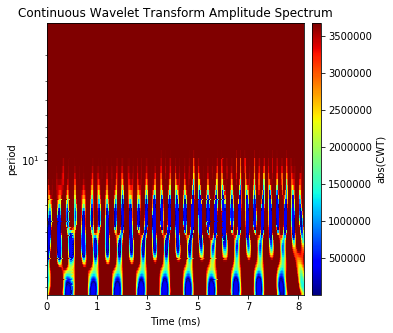

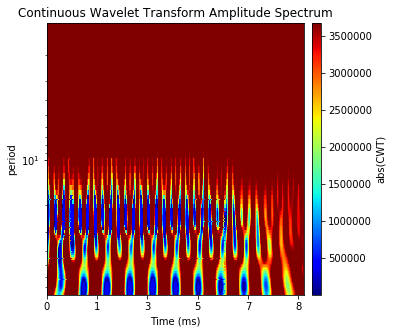

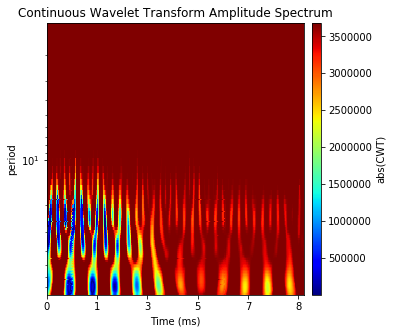

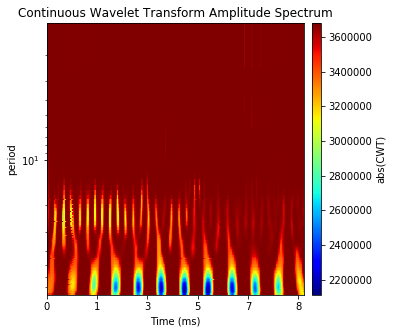

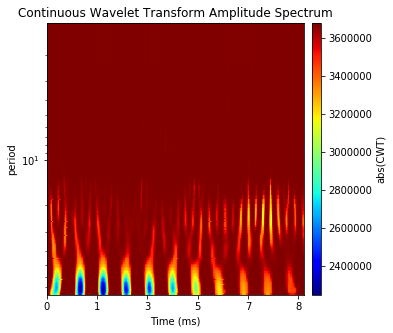

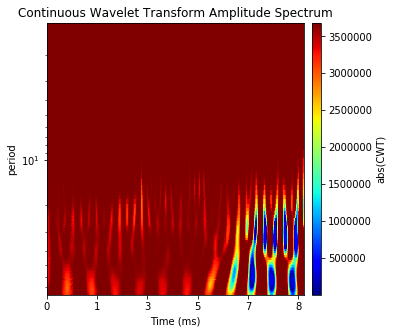

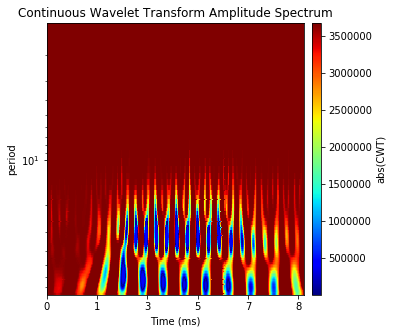

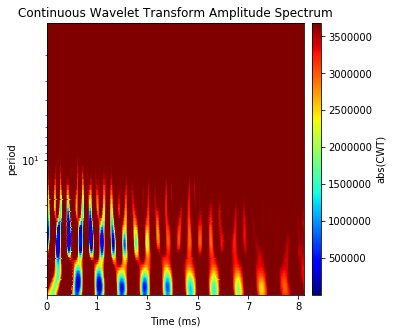

In [9]:
to=aespeech.destandard(to)
if rep=='spec':
    aespeech.show_spectrograms(mat,to)
if rep=='wvlt':
    aespeech.show_scalograms(np.arange(TIME_STEPS),to[20:30,:,:,:], freqs, hop=2, yaxis='period', ylabel='period')


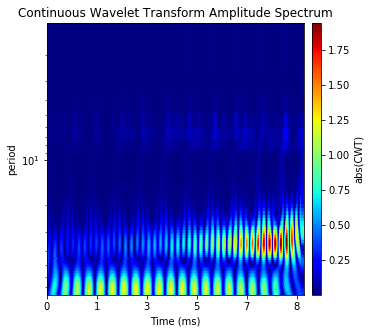

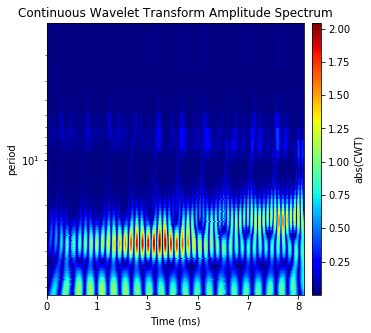

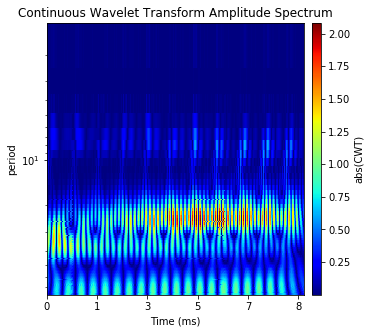

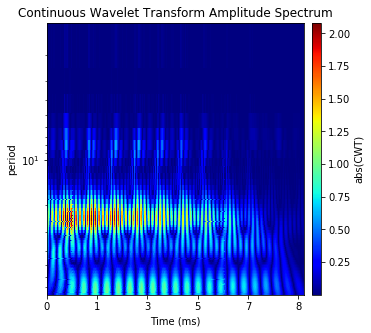

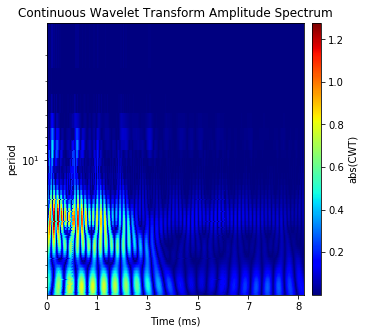

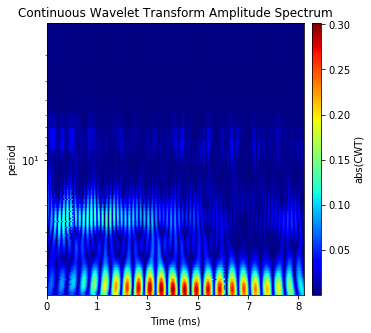

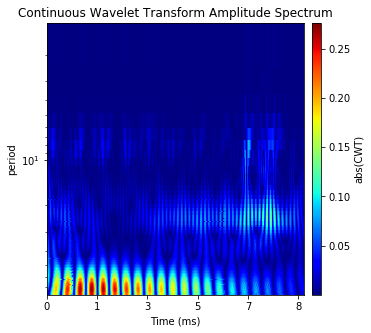

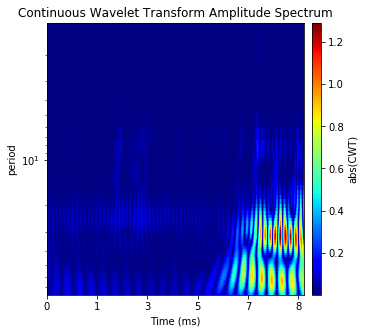

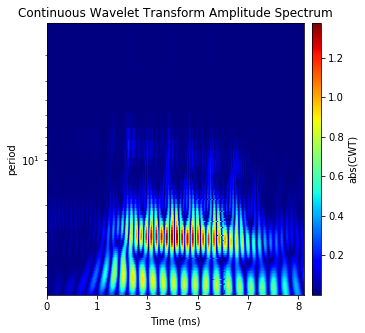

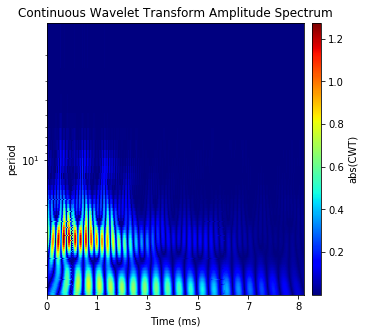

In [10]:
to=aespeech.destandard(to)
if rep=='spec':
    aespeech.show_spectrograms(mat,to)
if rep=='wvlt':
    aespeech.show_scalograms(np.arange(TIME_STEPS),mat[20:30,:,:,:], freqs, hop=2, yaxis='period', ylabel='period')
